In [ ]:
pip install notebook

# Importando bibliotecas

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
import pyspark.sql

# Iniciando sessão spark, importando e relacionando dados

In [3]:
spark = SparkSession.builder.appName("Supermarket Analytics").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [4]:
produtos = spark.read.csv('./base_de_dados/products.csv', sep=',', header=True)
corredores = spark.read.csv('./base_de_dados/aisles.csv', sep=',', header=True)
departamentos = spark.read.csv('./base_de_dados/departments.csv', sep=',', header=True)

In [5]:
produtos = produtos.join(corredores, 'aisle_id')
produtos = produtos.join(departamentos, 'department_id').select('product_id', 'product_name', 'aisle', 'department')

In [6]:
pedidos = spark.read.csv('./base_de_dados/orders.csv', sep=',', header=True)
produtos_por_pedido = spark.read.csv('./base_de_dados/order_products__train.csv', sep=',', header=True)

In [7]:
produtos.show()

+----------+--------------------+--------------------+---------------+
|product_id|        product_name|               aisle|     department|
+----------+--------------------+--------------------+---------------+
|         1|Chocolate Sandwic...|       cookies cakes|         snacks|
|         2|    All-Seasons Salt|   spices seasonings|         pantry|
|         3|Robust Golden Uns...|                 tea|      beverages|
|         4|Smart Ones Classi...|        frozen meals|         frozen|
|         5|Green Chile Anyti...|marinades meat pr...|         pantry|
|         6|        Dry Nose Oil|    cold flu allergy|  personal care|
|         7|Pure Coconut Wate...|       juice nectars|      beverages|
|         8|Cut Russet Potato...|      frozen produce|         frozen|
|         9|Light Strawberry ...|              yogurt|     dairy eggs|
|        10|Sparkling Orange ...|water seltzer spa...|      beverages|
|        11|   Peach Mango Juice|        refrigerated|      beverages|
|     

In [8]:
pedidos.show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|               08|                  NULL|
| 2398795|      1|   prior|           2|        3|               07|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|               07|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
| 3367565|      1|   prior|           6|        2|               07|                  19.0|
|  550135|      1|   prior|           7|        1|               09|                  20.0|
| 3108588|      1|   prior|           8|        1|               14|            

In [9]:
produtos_por_pedido.show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
|       1|     13176|                6|        0|
|       1|     47209|                7|        0|
|       1|     22035|                8|        1|
|      36|     39612|                1|        0|
|      36|     19660|                2|        1|
|      36|     49235|                3|        0|
|      36|     43086|                4|        1|
|      36|     46620|                5|        1|
|      36|     34497|                6|        1|
|      36|     48679|                7|        1|
|      36|     46979|                8|        1|
|      38|     11913|                1|        0|


# Etapa de verificação limpeza dos dados

In [10]:
#Dropando duplicatas se houver
produtos = produtos.dropDuplicates()
pedidos = pedidos.dropDuplicates()
produtos_por_pedido = produtos_por_pedido.dropDuplicates()

Tentando identificar valores inconsistentes nos dados

In [11]:
#Começando com a tabela produtos
produtos.columns

['product_id', 'product_name', 'aisle', 'department']

In [12]:
def reformatar_string(df, table_name) -> pyspark.sql.DataFrame:
    df.withColumn(table_name, lower(regexp_replace(table_name, "[^a-zA-Z0-9\\s]", "")))
    return df

In [13]:
def cast_var_int(pedidos, table_name) -> pyspark.sql.DataFrame:
    return pedidos.withColumn(table_name, col(table_name).cast("int"))

In [14]:
pedidos = cast_var_int(pedidos, 'order_hour_of_day')
pedidos = cast_var_int(pedidos, 'days_since_prior_order')

In [15]:
produtos.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)


In [16]:
produtos.select('product_id').distinct().count()

49687

In [17]:
produtos = produtos.dropDuplicates(subset=['product_id'])

In [18]:
produtos.select('product_id').distinct().count()

49687

In [19]:
departamentos = produtos.select('department').distinct().collect()
txt = ''
i=0
for row in departamentos:
    if i==2:
        txt += f'{row.department},\n'
        i=0
        continue
    txt += f'{row.department},\t'
    i += 1
print(txt)

beverages,	meat seafood,	frozen,
deli,	dry goods pasta,	bulk,
other,	babies,	bakery,
produce,	pantry,	dairy eggs,
canned goods,	personal care,	breakfast,
missing,	pets,	household,
alcohol,	international,	snacks,


Detectamos uma primeira inconsistencia, há departamentos nao listados classificados como missing, logo mais iremos analisar melhor o comportamento e a frequência desses departamentos missing, mas por enquanto vamos continuar

In [20]:
produtos.select('product_name').distinct().count()

49687

In [21]:
produtos = reformatar_string(produtos, 'product_name')

In [22]:
produtos.select('product_name').distinct().count()

49687

In [23]:
produtos = produtos.dropDuplicates()
produtos.select('product_id').distinct().count()

49687

In [24]:
produtos.select('*').filter(col('product_name') == 'cookies n cream ice cream').show(truncate=False)

+----------+------------+-----+----------+
|product_id|product_name|aisle|department|
+----------+------------+-----+----------+
+----------+------------+-----+----------+


Segunda inconsistência encontrada, por algum erro de formatação alguns produtos estavam sendo classificados como diferentes, mesmo sendo os mesmos, mas nós vimos e corrigimos a medida do possível, infelizmente não podemos dropa-los, por conta que isso poderia resultar em dados nulos dos produtos em pedidos, mas isso não vai atrapalhar nossa análise, pois ja que resolvemos o problema do nome, agora ele é único e todos que possuirem id's diferentes será classificado com o nome igual e se convertemos o nome em um dado ordinal para treinar um modelo mais a frente, poderá ser feito sem grandes dificuldades

In [25]:
produtos.select('aisle').distinct().count()

134

In [26]:
produtos = reformatar_string(produtos, 'aisle')

In [27]:
produtos.select('aisle').distinct().count()

134

In [28]:
corredores = produtos.select('aisle').distinct().collect()
txt = ''
i=0
for row in corredores:
    if i==2:
        txt += f'{row.aisle},\n'
        i=0
        continue
    txt += f'{row.aisle},\t'
    i += 1
print(txt)

bulk dried fruits vegetables,	refrigerated,	soy lactosefree,
instant foods,	trail mix snack mix,	trash bags liners,
fresh fruits,	asian foods,	hair care,
beers coolers,	feminine care,	frozen produce,
crackers,	fresh dips tapenades,	fresh herbs,
kitchen supplies,	condiments,	yogurt,
beauty,	laundry,	kosher foods,
buns rolls,	facial care,	pickled goods olives,
cat food care,	other creams cheeses,	cream,
muscles joints pain relief,	energy sports drinks,	diapers wipes,
soap,	cleaning products,	mint gum,
eye ear care,	energy granola bars,	prepared soups salads,
specialty wines champagnes,	honeys syrups nectars,	packaged meat,
tortillas flat bread,	oils vinegars,	canned jarred vegetables,
chips pretzels,	packaged vegetables fruits,	ice cream toppings,
prepared meals,	protein meal replacements,	cocoa drink mixes,
other,	latino foods,	preserved dips spreads,
skin care,	water seltzer sparkling water,	packaged seafood,
frozen meat seafood,	ice cream ice,	frozen pizza,
eggs,	pasta sauce,	first ai

Encontramos um tipo other e um tipo missing, vamos dar uma analisada melhor mais tarde

In [29]:
# Agora vamos analisar pedidos
pedidos.columns

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

In [30]:
pedidos = cast_var_int(pedidos, 'order_number')
pedidos = cast_var_int(pedidos, 'order_dow')
pedidos = cast_var_int(pedidos, 'order_hour_of_day')
pedidos = cast_var_int(pedidos, 'days_since_prior_order')

In [31]:
pedidos.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: integer (nullable = true)


order_id como primary key

In [32]:
pedidos.count()

3421083

In [33]:
pedidos = pedidos.dropDuplicates(subset=['order_id'])

In [34]:
pedidos.count()

3421083

order_number com valores negativos ou iguais a 0

In [35]:
pedidos.filter(col("order_number") <= 0).show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
+--------+-------+--------+------------+---------+-----------------+----------------------+


Vendo amplitude de order_hour_of_day

In [36]:
max_valor = pedidos.agg(max("order_hour_of_day")).collect()[0][0]
min_valor = pedidos.agg(min("order_hour_of_day")).collect()[0][0]

print(f'Maior valor: {max_valor}\nMenor Valor: {min_valor}\nAmplitude: {max_valor - min_valor}')

Maior valor: 23
Menor Valor: 0
Amplitude: 23


Vendo amplitude de days_since_prior_order

In [37]:
max_valor = pedidos.agg(max("days_since_prior_order")).collect()[0][0]
min_valor = pedidos.agg(min("days_since_prior_order")).collect()[0][0]

print(f'Maior valor: {max_valor}\nMenor Valor: {min_valor}\nAmplitude: {max_valor - min_valor}')

Maior valor: 30
Menor Valor: 0
Amplitude: 30


In [38]:
#Por último produtos por pedido
produtos_por_pedido.columns

['order_id', 'product_id', 'add_to_cart_order', 'reordered']

In [39]:
produtos_por_pedido = cast_var_int(produtos_por_pedido, 'add_to_cart_order')
produtos_por_pedido = cast_var_int(produtos_por_pedido, 'reordered')

In [40]:
produtos_por_pedido.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)


produtos_por_pedido

In [41]:
max_valor = produtos_por_pedido.agg(max("add_to_cart_order")).collect()[0][0]
min_valor = produtos_por_pedido.agg(min("add_to_cart_order")).collect()[0][0]

print(f'Maior valor: {max_valor}\nMenor Valor: {min_valor}\nAmplitude: {max_valor - min_valor}')

Maior valor: 80
Menor Valor: 1
Amplitude: 79


In [42]:
max_valor = produtos_por_pedido.agg(max("reordered")).collect()[0][0]
min_valor = produtos_por_pedido.agg(min("reordered")).collect()[0][0]

print(f'Maior valor: {max_valor}\nMenor Valor: {min_valor}\nAmplitude: {max_valor - min_valor}')

Maior valor: 1
Menor Valor: 0
Amplitude: 1


# Preparando os dados

In [43]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

windowSpec = Window.orderBy().rowsBetween(Window.unboundedPreceding, Window.currentRow)

Verificando valores nulos

In [51]:
import pyspark.sql.functions as F


nulos = produtos.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + 'nulos')
    for c in produtos.columns
])

# Coletar e exibir os resultados
null_percentage = nulos.collect()[0]
for column in produtos.columns:
    print(f"{column}: {null_percentage[column+'nulos'] * 100:.2f}% de valores nulos")

product_id: 0.00% de valores nulos
product_name: 0.00% de valores nulos
aisle: 0.00% de valores nulos
department: 0.00% de valores nulos


In [66]:
import pyspark.sql.functions as F


nulos = pedidos.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + 'nulos')
    for c in pedidos.columns
])

# Coletar e exibir os resultados
null_percentage = nulos.collect()[0]
for column in pedidos.columns:
    print(f"{column}: {null_percentage[column+'nulos'] * 100:.2f}% de valores nulos")

order_id: 0.00% de valores nulos
user_id: 0.00% de valores nulos
eval_set: 0.00% de valores nulos
order_number: 0.00% de valores nulos
order_dow: 0.00% de valores nulos
order_hour_of_day: 0.00% de valores nulos
days_since_prior_order: 6.03% de valores nulos


In [67]:
import pyspark.sql.functions as F



nulos = produtos_por_pedido.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + 'nulos')
    for c in produtos_por_pedido.columns
])

# Coletar e exibir os resultados
null_percentage = nulos.collect()[0]
for column in produtos_por_pedido.columns:
    print(f"{column}: {null_percentage[column+'nulos'] * 100:.2f}% de valores nulos")

order_id: 0.00% de valores nulos
product_id: 0.00% de valores nulos
add_to_cart_order: 0.00% de valores nulos
reordered: 0.00% de valores nulos


Criando views e listando todas as colunas

In [44]:
produtos.createOrReplaceTempView('produtos')
pedidos.createOrReplaceTempView('pedidos')
produtos_por_pedido.createOrReplaceTempView('produtos_por_pedido')

In [63]:
print(f'{produtos.columns}\n{pedidos.columns}\n{produtos_por_pedido.columns}')

['product_id', 'product_name', 'aisle', 'department']
['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
['order_id', 'product_id', 'add_to_cart_order', 'reordered']


# Análise 1: Departamentos que mais vendem e seus produtos

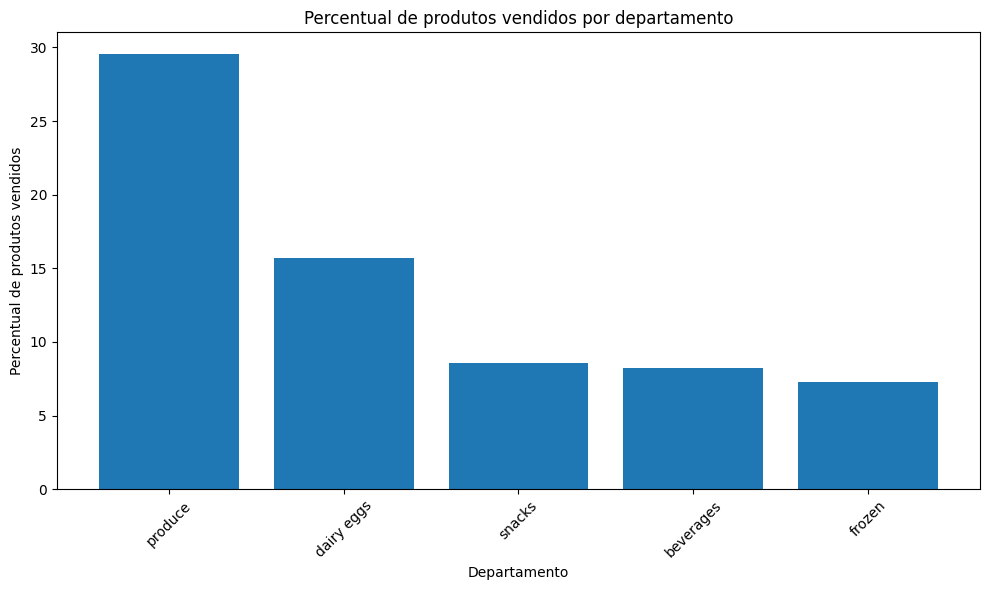

In [83]:
from pyspark.sql.window import Window

pareto = spark.sql('SELECT p.department, COUNT(pp.product_id) AS produtos_totais \
          FROM produtos_por_pedido pp \
          INNER JOIN produtos p ON p.product_id = pp.product_id \
          GROUP BY p.department \
          ORDER BY produtos_totais DESC')


pareto = pareto.withColumn('produtos_totais_percentuais', 
                                 F.round((F.col('produtos_totais') / F.sum('produtos_totais').over(Window.partitionBy())) * 100, 2)) \
                    .withColumn('produtos_totais_percentuais_acumulados', 
                                 F.round(F.sum('produtos_totais_percentuais').over(windowSpec), 2))

# Lembrando que o diagrama de pareto esta relacionado a regra dos 80/20, com base nisso vamos pegar os 20% dos primeiros departamentos que ao todo são 5 
pareto = pareto.limit(5)

pandas_pareto = pareto.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(pandas_pareto['department'], pandas_pareto['produtos_totais_percentuais'])
plt.xlabel('Departamento')
plt.ylabel('Percentual de produtos vendidos')
plt.title('Percentual de produtos vendidos por departamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show() 

In [66]:
Produtos = {}
for departament in pandas_pareto['department'].unique():
        products = spark.sql(f'SELECT p.product_name, p.department, COUNT(pp.product_id) AS produtos_totais \
        FROM produtos_por_pedido pp \
        INNER JOIN produtos p ON p.product_id = pp.product_id \
        WHERE p.department = "{departament}" \
        GROUP BY p.product_name, p.department \
        ORDER BY produtos_totais DESC')

        products = products.withColumn('produtos_totais_percentuais', 
                                 F.round((F.col('produtos_totais') / F.sum('produtos_totais').over(Window.partitionBy())) * 100, 2)) \
                    .withColumn('produtos_totais_percentuais_acumulados', 
                                 F.round(F.sum('produtos_totais_percentuais').over(windowSpec), 2))
        Produtos[departament] = products

In [82]:
# produce    frozen     dairy eggs     snacks     beverages #

for departament in pandas_pareto['department'].unique():
    print(Produtos[departament].show())

+--------------------+----------+---------------+---------------------------+--------------------------------------+
|        product_name|department|produtos_totais|produtos_totais_percentuais|produtos_totais_percentuais_acumulados|
+--------------------+----------+---------------+---------------------------+--------------------------------------+
|              banana|   produce|          18726|                       4.58|                                  4.58|
|bag of organic ba...|   produce|          15480|                       3.78|                                  8.36|
|organic strawberries|   produce|          10894|                       2.66|                                 11.02|
|organic baby spinach|   produce|           9784|                       2.39|                                 13.41|
|         large lemon|   produce|           8135|                       1.99|                                  15.4|
|     organic avocado|   produce|           7409|               

In [ ]:
plt.figure(figsize=(20, 20))

for i, departament in enumerate(pandas_pareto['department'].unique()):
    aux = Produtos[departament].toPandas()
    plt.subplot(5, 1, i+1)
    plt.bar(aux['product_name'].head(6), aux['produtos_totais_percentuais'].head(6))
    plt.title(f'Produtos mais vendidos: {departament}')
    plt.ylabel('Frequência relativa percentual')

plt.tight_layout()

plt.show()

Tomada de decisão: Otimizar o Estoque e Aumentar a Receita com Produtos Mais Vendidos

# Análise 2: Horários que mais vendem

In [58]:
horarios = pedidos.select('order_hour_of_day').groupby('order_hour_of_day').count().orderBy('order_hour_of_day')

horarios = horarios.withColumn('percentual_order_hour_of_day', 
                                 F.round((F.col('count') / F.sum('count').over(Window.partitionBy())) * 100, 2)) 

horarios.show()

+-----------------+------+----------------------------+
|order_hour_of_day| count|percentual_order_hour_of_day|
+-----------------+------+----------------------------+
|                0| 22758|                        0.67|
|                1| 12398|                        0.36|
|                2|  7539|                        0.22|
|                3|  5474|                        0.16|
|                4|  5527|                        0.16|
|                5|  9569|                        0.28|
|                6| 30529|                        0.89|
|                7| 91868|                        2.69|
|                8|178201|                        5.21|
|                9|257812|                        7.54|
|               10|288418|                        8.43|
|               11|284728|                        8.32|
|               12|272841|                        7.98|
|               13|277999|                        8.13|
|               14|283042|                      

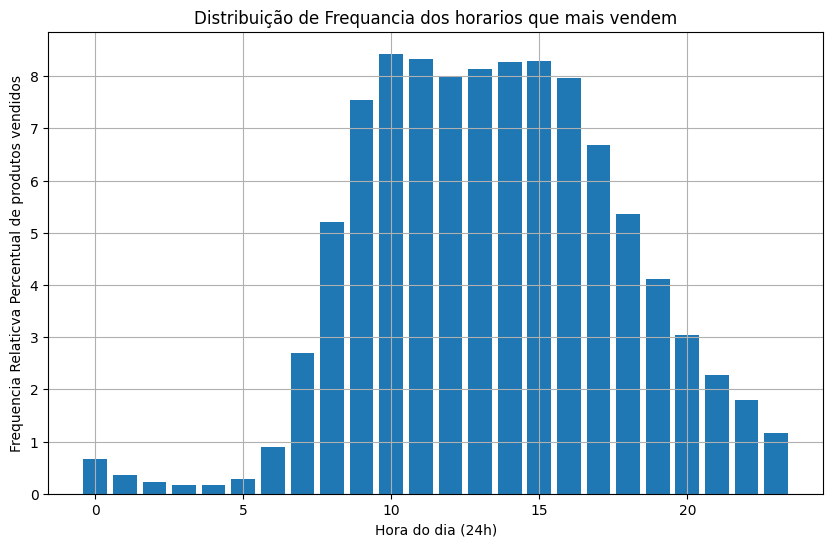

In [61]:
df_horarios = horarios.toPandas()

plt.figure(figsize=(10,6))
plt.bar(df_horarios['order_hour_of_day'], df_horarios['percentual_order_hour_of_day'])
plt.xlabel('Hora do dia (24h)')
plt.ylabel('Frequencia Relaticva Percentual de produtos vendidos')
plt.title('Distribuição de Frequancia dos horarios que mais vendem')
plt.grid(True)
plt.show()

Os horarios de maior venda são de 9 a 17

In [119]:
horas = np.arange(9, 18)

Produtos_mais_vendidos_por_hora = {}

for hora in horas:
    hora_produtos = spark.sql(f'SELECT DISTINCT p.product_name, COUNT(p.product_name) AS Quantidade, pe.order_hour_of_day \
            FROM produtos p \
            INNER JOIN produtos_por_pedido ppp ON ppp.product_id = p.product_id \
            INNER JOIN pedidos pe ON ppp.order_id = pe.order_id \
            WHERE pe.order_hour_of_day = {hora} \
            GROUP BY p.product_name, pe.order_hour_of_day \
            ORDER BY Quantidade DESC')

    hora_produtos = hora_produtos.withColumn('Quantidade Relativa Percentual', 
                                    F.round((F.col('Quantidade') / F.sum('Quantidade').over(Window.partitionBy())) * 100, 2)) \
                        .withColumn('Quantidade Relativa Percentual Acumulada', 
                                    F.round(F.sum('Quantidade Relativa Percentual').over(windowSpec), 2))
    Produtos_mais_vendidos_por_hora[hora] = hora_produtos

In [124]:
# Horas de pico [9-17] #

for hora in horas:
    print(Produtos_mais_vendidos_por_hora[hora].show())

+--------------------+----------+-----------------+------------------------------+----------------------------------------+
|        product_name|Quantidade|order_hour_of_day|Quantidade Relativa Percentual|Quantidade Relativa Percentual Acumulada|
+--------------------+----------+-----------------+------------------------------+----------------------------------------+
|              banana|      1372|                9|                          1.46|                                    1.46|
|bag of organic ba...|      1101|                9|                          1.17|                                    2.63|
|organic strawberries|       730|                9|                          0.78|                                    3.41|
|organic baby spinach|       647|                9|                          0.69|                                     4.1|
|         large lemon|       561|                9|                           0.6|                                     4.7|
|organic

In [55]:
horas = np.arange(9, 18)

Produtos_mais_vendidos_por_hora_dep = {}

for hora in horas:
    hora_departamento = spark.sql(f'SELECT p.department, COUNT(p.product_name) AS Quantidade, pe.order_hour_of_day \
            FROM produtos p \
            INNER JOIN produtos_por_pedido ppp ON ppp.product_id = p.product_id \
            INNER JOIN pedidos pe ON ppp.order_id = pe.order_id \
            WHERE pe.order_hour_of_day = {hora} \
            GROUP BY p.department, pe.order_hour_of_day \
            ORDER BY Quantidade DESC')

    hora_departamento = hora_departamento.withColumn('Quantidade Relativa Percentual', 
                                    F.round((F.col('Quantidade') / F.sum('Quantidade').over(Window.partitionBy())) * 100, 2)) \
                        .withColumn('Quantidade Relativa Percentual Acumulada', 
                                    F.round(F.sum('Quantidade Relativa Percentual').over(windowSpec), 2))
    Produtos_mais_vendidos_por_hora_dep[hora] = hora_departamento

In [56]:
for hora in horas:
    print(Produtos_mais_vendidos_por_hora_dep[hora].show())

+---------------+----------+-----------------+------------------------------+----------------------------------------+
|     department|Quantidade|order_hour_of_day|Quantidade Relativa Percentual|Quantidade Relativa Percentual Acumulada|
+---------------+----------+-----------------+------------------------------+----------------------------------------+
|        produce|     27891|                9|                         29.72|                                   29.72|
|     dairy eggs|     15146|                9|                         16.14|                                   45.86|
|         snacks|      8270|                9|                          8.81|                                   54.67|
|      beverages|      8185|                9|                          8.72|                                   63.39|
|         frozen|      5955|                9|                          6.34|                                   69.73|
|         pantry|      5218|                9|  

Tomada de decisão: Otimizar Logistica baseado nos produtos e departamentos que possuem maior frequência de compra 

# Análise 3: O produto mais requisitado, o mais procurado e o que mais vende

Essa análise é baseada nos produtos que foram adicionados em primeiro aos carrinhos

In [49]:
produtos_mais_procurados = spark.sql('SELECT DISTINCT p.product_name, p.department, COUNT(p.product_name) AS produtos_totais \
        FROM produtos_por_pedido pp \
        INNER JOIN produtos p ON p.product_id = pp.product_id \
        WHERE pp.add_to_cart_order = "1" \
        GROUP BY p.product_name, p.department \
        ORDER BY produtos_totais DESC')

produtos_mais_procurados = produtos_mais_procurados.withColumn('Requisicao Relativa Percentual', 
                                F.round((F.col('produtos_totais') / F.sum('produtos_totais').over(Window.partitionBy())) * 100, 2)) \
                .withColumn('Requisicao Relativa Percentual Acumulada', 
                                F.round(F.sum('Requisicao Relativa Percentual').over(windowSpec), 2))

produtos_mais_procurados.show()

+--------------------+----------+---------------+------------------------------+----------------------------------------+
|        product_name|department|produtos_totais|Requisicao Relativa Percentual|Requisicao Relativa Percentual Acumulada|
+--------------------+----------+---------------+------------------------------+----------------------------------------+
|              banana|   produce|           4605|                          3.51|                                    3.51|
|bag of organic ba...|   produce|           3889|                          2.96|                                    6.47|
|  organic whole milk|dairy eggs|           1144|                          0.87|                                    7.34|
|     organic avocado|   produce|            995|                          0.76|                                     8.1|
|organic strawberries|   produce|            900|                          0.69|                                    8.79|
|organic baby spinach|  

Esta análise é baseada na quantidade de vezes que o produto foi comprado novamente pelos clientes

In [52]:
produtos_mais_requisitado = spark.sql('SELECT DISTINCT p.product_name, p.department, COUNT(p.product_name) AS produtos_totais \
        FROM produtos_por_pedido pp \
        INNER JOIN produtos p ON p.product_id = pp.product_id \
        WHERE pp.reordered = "1" \
        GROUP BY p.product_name, p.department \
        ORDER BY produtos_totais DESC')

produtos_mais_requisitado = produtos_mais_requisitado.withColumn('Requisicao Relativa Percentual', 
                                F.round((F.col('produtos_totais') / F.sum('produtos_totais').over(Window.partitionBy())) * 100, 2)) \
                .withColumn('Requisicao Relativa Percentual Acumulada', 
                                F.round(F.sum('Requisicao Relativa Percentual').over(windowSpec), 2))

produtos_mais_requisitado.show()

+--------------------+----------+---------------+------------------------------+----------------------------------------+
|        product_name|department|produtos_totais|Requisicao Relativa Percentual|Requisicao Relativa Percentual Acumulada|
+--------------------+----------+---------------+------------------------------+----------------------------------------+
|              banana|   produce|          16557|                           2.0|                                     2.0|
|bag of organic ba...|   produce|          13362|                          1.61|                                    3.61|
|organic strawberries|   produce|           8603|                          1.04|                                    4.65|
|organic baby spinach|   produce|           8055|                          0.97|                                    5.62|
|     organic avocado|   produce|           6226|                          0.75|                                    6.37|
|organic hass avocado|  

Esta análise é baseasa na soma total de todos os produtos vendidos por produto

In [53]:
produtos_mais_vendidos = spark.sql('SELECT DISTINCT p.product_name, p.department, COUNT(p.product_name) AS produtos_totais \
        FROM produtos_por_pedido pp \
        INNER JOIN produtos p ON p.product_id = pp.product_id \
        GROUP BY p.product_name, p.department \
        ORDER BY produtos_totais DESC')

produtos_mais_vendidos = produtos_mais_vendidos.withColumn('Requisicao Relativa Percentual', 
                                F.round((F.col('produtos_totais') / F.sum('produtos_totais').over(Window.partitionBy())) * 100, 2)) \
                .withColumn('Requisicao Relativa Percentual Acumulada', 
                                F.round(F.sum('Requisicao Relativa Percentual').over(windowSpec), 2))

produtos_mais_vendidos.show()

+--------------------+----------+---------------+------------------------------+----------------------------------------+
|        product_name|department|produtos_totais|Requisicao Relativa Percentual|Requisicao Relativa Percentual Acumulada|
+--------------------+----------+---------------+------------------------------+----------------------------------------+
|              banana|   produce|          18726|                          1.35|                                    1.35|
|bag of organic ba...|   produce|          15480|                          1.12|                                    2.47|
|organic strawberries|   produce|          10894|                          0.79|                                    3.26|
|organic baby spinach|   produce|           9784|                          0.71|                                    3.97|
|         large lemon|   produce|           8135|                          0.59|                                    4.56|
|     organic avocado|  

Tomada de decisão: Estratégia de marketing com ofertas e descontos para atrair mais publico ou aumentar a oferta baseado na demanda

# Análise 4: Segmentação de clientes

In [78]:
segmentacao_de_cliente = spark.sql("""SELECT user_id,
            avg_days,
            product_name,
            CASE
                WHEN avg_days < 10 THEN 'Frequente'
                WHEN avg_days BETWEEN 10 AND 20 THEN 'Moderado'
                ELSE 'Raro'
            END AS segmento
        FROM (
            SELECT p.user_id, AVG(p.days_since_prior_order) AS avg_days, pd.product_name
            FROM pedidos p
            INNER JOIN produtos_por_pedido pp ON pp.order_id = p.order_id
            INNER JOIN produtos pd ON pp.product_id = pd.product_id
            GROUP BY p.user_id, pd.product_name
        ) AS subquery;
""")

seg = segmentacao_de_cliente.select('segmento').groupby('segmento').count()

seg = seg.withColumn('Segmentacao Relativa percentual', 
                                F.round((F.col('count') / F.sum('count').over(Window.partitionBy())) * 100, 2))

print(seg.show())
print(segmentacao_de_cliente.show())

+---------+------+-------------------------------+
| segmento| count|Segmentacao Relativa percentual|
+---------+------+-------------------------------+
|     Raro|565036|                          40.81|
| Moderado|335183|                          24.21|
|Frequente|484373|                          34.98|
+---------+------+-------------------------------+

None
+-------+--------+--------------------+---------+
|user_id|avg_days|        product_name| segmento|
+-------+--------+--------------------+---------+
|  35663|    25.0|dairy free vanill...|     Raro|
|  12109|     0.0|tortilla chips cl...|Frequente|
| 164473|    17.0|organic garnet sw...| Moderado|
| 164483|    30.0|           asparagus|     Raro|
| 173429|    30.0|   mild chunky salsa|     Raro|
|  84915|    29.0|jalapeno potato c...|     Raro|
| 140481|    30.0|        tomato sauce|     Raro|
|  39502|     7.0|       honey yoghurt|Frequente|
|  36386|    30.0|organic tomato cl...|     Raro|
| 203642|    30.0|mexican style fou..

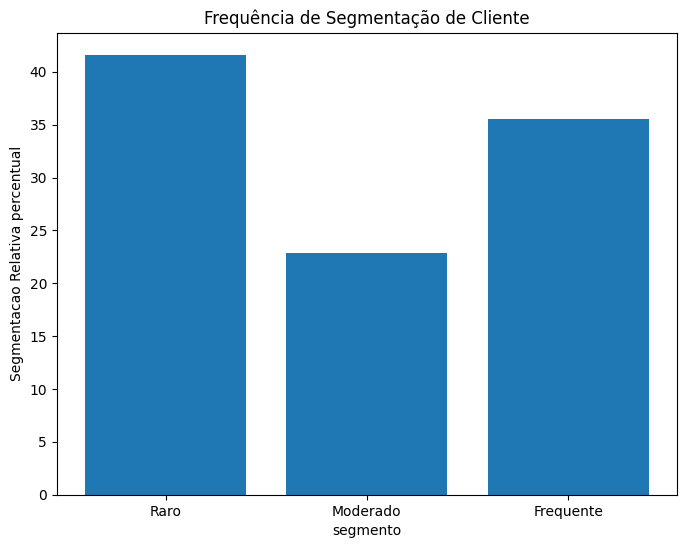

In [74]:
pandas_segmentacao = seg.toPandas()

plt.figure(figsize=(8,6))
plt.title('Frequência de Segmentação de Cliente')
plt.bar(pandas_segmentacao['segmento'], pandas_segmentacao['Segmentacao Relativa percentual'])
plt.xlabel('segmento')
plt.ylabel('Segmentacao Relativa percentual')
#plt.grid(True)
plt.show()

In [85]:
#Produtos mais comprados dos clientes frequentes
produtos_frequentes = segmentacao_de_cliente.filter(segmentacao_de_cliente.segmento == 'Frequente')

segmentacao_de_cliente.select('product_name').groupby('product_name').count().orderBy(desc('count')).show()

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|              banana|18726|
|bag of organic ba...|15480|
|organic strawberries|10894|
|organic baby spinach| 9784|
|         large lemon| 8135|
|     organic avocado| 7409|
|organic hass avocado| 7293|
|        strawberries| 6494|
|               limes| 6033|
| organic raspberries| 5546|
| organic blueberries| 4966|
|  organic whole milk| 4908|
|    organic cucumber| 4613|
|    organic zucchini| 4589|
|organic yellow onion| 4290|
|      organic garlic| 4158|
| seedless red grapes| 4059|
|           asparagus| 3868|
|organic grape tom...| 3823|
|   organic red onion| 3818|
+--------------------+-----+


In [84]:
#Produtos mais comprados dos clientes moderados
produtos_frequentes = segmentacao_de_cliente.filter(segmentacao_de_cliente.segmento == 'Moderado')

segmentacao_de_cliente.select('product_name').groupby('product_name').count().orderBy(desc('count')).show()

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|              banana|18726|
|bag of organic ba...|15480|
|organic strawberries|10894|
|organic baby spinach| 9784|
|         large lemon| 8135|
|     organic avocado| 7409|
|organic hass avocado| 7293|
|        strawberries| 6494|
|               limes| 6033|
| organic raspberries| 5546|
| organic blueberries| 4966|
|  organic whole milk| 4908|
|    organic cucumber| 4613|
|    organic zucchini| 4589|
|organic yellow onion| 4290|
|      organic garlic| 4158|
| seedless red grapes| 4059|
|           asparagus| 3868|
|organic grape tom...| 3823|
|   organic red onion| 3818|
+--------------------+-----+


In [86]:
#Produtos mais comprados dos clientes raros
produtos_frequentes = segmentacao_de_cliente.filter(segmentacao_de_cliente.segmento == 'Raro')

segmentacao_de_cliente.select('product_name').groupby('product_name').count().orderBy(desc('count')).show()

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|              banana|18726|
|bag of organic ba...|15480|
|organic strawberries|10894|
|organic baby spinach| 9784|
|         large lemon| 8135|
|     organic avocado| 7409|
|organic hass avocado| 7293|
|        strawberries| 6494|
|               limes| 6033|
| organic raspberries| 5546|
| organic blueberries| 4966|
|  organic whole milk| 4908|
|    organic cucumber| 4613|
|    organic zucchini| 4589|
|organic yellow onion| 4290|
|      organic garlic| 4158|
| seedless red grapes| 4059|
|           asparagus| 3868|
|organic grape tom...| 3823|
|   organic red onion| 3818|
+--------------------+-----+


Tomada de decisão: Fidelizações de clientes e diversificações de Produtos

In [23]:
spark.catalog.dropTempView("produtos")
spark.catalog.dropTempView("pedidos")
spark.catalog.dropTempView("produtos_por_pedido")

True

# Análise 5: Corredores com maiores quantidades de vendas

['product_id', 'product_name', 'aisle', 'department']
['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
['order_id', 'product_id', 'add_to_cart_order', 'reordered']

In [49]:
corredores = spark.sql('SELECT p.aisle, COUNT(p.product_name) AS Count \
          FROM produtos p \
          INNER JOIN produtos_por_pedido pp ON pp.product_id=p.product_id \
          GROUP BY p.aisle \
          ORDER BY Count DESC')

corredores = corredores.withColumn('Vendas Relativs Percentuais', 
                                F.round((F.col('Count') / F.sum('Count').over(Window.partitionBy())) * 100, 2)) \
                .withColumn('Vendas Relativs Percentuais Acumulada', 
                                F.round(F.sum('Vendas Relativs Percentuais').over(windowSpec), 2))

corredores.show()

+--------------------+------+---------------------------+-------------------------------------+
|               aisle| Count|Vendas Relativs Percentuais|Vendas Relativs Percentuais Acumulada|
+--------------------+------+---------------------------+-------------------------------------+
|    fresh vegetables|150609|                      10.88|                                10.88|
|        fresh fruits|150473|                      10.87|                                21.75|
|packaged vegetabl...| 78493|                       5.67|                                27.42|
|              yogurt| 55240|                       3.99|                                31.41|
|     packaged cheese| 41699|                       3.01|                                34.42|
|water seltzer spa...| 36617|                       2.64|                                37.06|
|                milk| 32644|                       2.36|                                39.42|
|      chips pretzels| 31269|           

Tomada de decisão: Otimizar logistica de tais corredores, e trabalhar na diversidade de produtos vendidos 